In [2]:
%matplotlib inline
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pystan
import pickle
import h5py
from six import string_types
import phasekick
import pmefm
import lockin
from scipy.optimize import curve_fit
from scipy import optimize
from scipy import stats
from tqdm import tqdm
from scipy import signal
import sigutils
from sigutils import log_bins
import freqphasenoise


def mask_xy(x, y, xmin, xmax):
    x_masked = []
    y_masked = []
    for x_, y_ in zip(x, y):
        m = (x_ >= xmin) & (x_ < xmax)
        x_masked.append(x_[m])
        y_masked.append(y_[m])
    
    x_masked = np.array(x_masked)
    y_masked = np.array(y_masked)
    return x_masked, y_masked

def centered(fir, fs):
    N = fir.size
    return (np.arange(N) - (N-1)/2.)/fs


def intercept_filter(N):
    return 2*(2*N - 1 - 3*np.arange(N))/(N*(N+1))

def workup_df(fname_or_fh, fp, fc, Vtdict,
              tiphase=None, tfphase=None,
              butter=None, periodogram=True):
    if isinstance(fname_or_fh, string_types):
        fh = h5py.File(fname_or_fh, 'r')
        fname = fname_or_fh
    else:
        fh = fname_or_fh
        fname = fh.filename

    lis = []
    for ds_name in tqdm(fh['ds']):
        li = phasekick.gr2lock(fh['data'][ds_name], fp=fp, fc=fc)
        if butter is not None:
            li.lock_butter(**butter)
        if tfphase is None:
            tfphase = -li.t2
        li.phase(ti=tiphase, tf=tfphase)
        lis.append(li)

    ts = np.array([li('t') for li in lis])
    dfs = np.array([li('df') for li in lis])
    dphis = np.array([li('dphi') for li in lis])

    dfs_masked = []
    ts_masked = []
    dphis_masked = []
    
    masked_times = {}
    
    for label, ((tmin, tmax), popt) in Vtdict.items():
        for t, df, dphi in zip(ts, dfs, dphis):
            m = (t >= tmin) & (t < tmax)
            ts_masked.append(t[m])
            dfs_masked.append(df[m])
            dphis_masked.append(dphi[m])

        ts_masked = np.array(ts_masked)
        dfs_masked = np.array(dfs_masked)
        dphis_masked = np.array(dphis_masked)

        t_func = phasekick.percentile_func(ts_masked)
        df_func = phasekick.percentile_func(dfs_masked)
        
        t = ts_masked - t_func(50)[0]
        dfs_resid = dfs_masked - lockin.expfall(t, *popt)
        dphis_resid = (dphis_masked - np.cumsum(lockin.expfall(t, *popt), axis=1)/li.fs*np.pi*2).T
        dphis_resid = (dphis_resid - dphis_resid.mean(axis=0)).T
        
        if periodogram:
            psd_f, psd_phi = signal.periodogram(dphis_resid/(2*np.pi), fs=li.fs)
            _, psd_df = signal.periodogram(dfs_resid, fs=li.fs)
        
        masked_times[label] = {
            'ts': ts_masked,
            'dfs': dfs_masked,
            'dfs_resid': dfs_resid,
            'dphis_resid': dphis_resid,
            'dphis': dphis_masked,
            'df_func': df_func,
            't_func': t_func,
            'psd_f': psd_f,
            'psd_phi': np.mean(psd_phi, axis=0),
            'psd_df': np.mean(psd_df, axis=0)
        }

    d = {'lis': lis,  'params': {
                'fname_or_fh': fname,
                'fp': fp,
                'fc': fc,
                'tiphase': tiphase,
                'tfphase': tfphase,
                'butter': butter,
                'Vtdict': Vtdict
            },
             'masked_times': masked_times
            }


    return d

# Power spectral density

In [3]:
filename = '../data/tr-efm/151217-200319-p1sun-df.h5'  
fh = h5py.File(filename, 'r')

In [4]:
lis = []
fp = 4000
fc = 15000
tmin = 0.055
tmax = 0.169
workups = {}

workups['815-10V-hv'] = phasekick.workup_df(fh, 5000, 15000, tmin, tmax)
workups['815-0V'] = phasekick.workup_df(fh, 5000, 15000, 0.171, 0.1995)
workups['104-0V'] = phasekick.workup_df(fh, 1000, 4000, 0.1715, 0.1985)
workups['104-0V-phi'] = phasekick.workup_df(fh, 1000, 4000, 0.1715, 0.1985)
workups['104-10V'] = phasekick.workup_df(fh, 1000, 4000, tmin, tmax-0.001)
workups['0502-0V'] = phasekick.workup_df(fh, 500, 2000, 0.1725, 0.1975)
workups['0502-0V-phi'] = phasekick.workup_df(fh, 500, 2000, 0.1725, 0.1975)
workups['0502-10V'] = phasekick.workup_df(fh, 500, 2000, tmin, tmax-0.002)


100%|██████████| 32/32 [00:05<00:00,  5.66it/s]


In [5]:
out0520 = workup_df(fh, 500, 2000, {0: ((0.1725, 0.1975), np.array([ 0.63894734,  0.00621252, -0.8297541]))})
out1040 = workup_df(fh, 1000, 4000, {0: ((0.1715, 0.1985), np.array([ 0.63894734,  0.00621252, -0.8297541]))})

100%|██████████| 32/32 [00:05<00:00,  6.43it/s]


# Figure 2 a,b, d,e

## 2a

In [6]:
fir0104 = lockin.lock2(f0=62e3, fp=1000, fc=4000, fs=1e6)

fir208 = lockin.lock2(62e3, 2e3, 8e3, 1e6)
fir0502 = workups['0502-0V']['lis'][0].fir

Response:
f   mag       dB
    0.000 1.000    0.000
  500.000 0.983   -0.151
 1000.000 0.927   -0.656
 4000.000 0.095  -20.474
 8000.000 0.000 -101.842
31000.000 0.000 -152.508
62000.000 0.000 -176.944
500000.000 0.000 -354.014
Response:
f   mag       dB
    0.000 1.000    0.000
 1000.000 0.983   -0.151
 2000.000 0.927   -0.657
 8000.000 0.095  -20.459
16000.000 0.000 -101.856
31000.000 0.000 -136.118
62000.000 0.000 -152.587
500000.000 0.000 -340.558


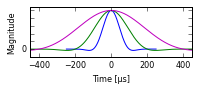

In [7]:
size = 8
labelsize=8
rcParams = {'figure.figsize': (4*0.75, 3*0.75), 'font.size': size,
            'lines.markersize': 6,
            'lines.linewidth': 1,
            'xtick.labelsize': labelsize, 'ytick.labelsize': labelsize,}

Asize = (2.9,0.9)

get_t = lambda fir, fs: (np.arange(fir.size) - (fir.size-1)/2) / fs

with mpl.rc_context(rcParams):
    fig, ax = plt.subplots(figsize=Asize)
    ax.plot(get_t(fir208, 1.), fir208/fir208.max(), 'b')
    ax.plot(get_t(fir0104, 1.), fir0104/fir0104.max(), 'g')
    ax.plot(get_t(fir0502, 1.), fir0502/fir0502.max(), 'm')
    ax.set_xlabel(u"Time [µs]", fontsize=8)
    ax.set_ylabel(u"Magnitude", fontsize=8)
    ax.set_ylim(-0.2, 1.1)
    ax.set_yticklabels(['', 0, '', '', '', '', ''])
    ax.set_xlim(-450, 450)
    fig.savefig('../figs/03a-lockin-magnitude.pdf', bbox_inches='tight')

## 2d

In [10]:
def get_weight_func(tau, fs):
    f = lambda x: stats.expon.pdf(x, scale=(tau*fs))
    return f

fs = 1e6
wb = 0.67e-3
wa = 1.2e-3
w_before = phasekick.expon_weights(wb, fs, 5)
w_after = phasekick.expon_weights(wa, fs, 5)
N_b = int(round(fs * wb * 5))
N_a = int(round(fs*wa*5))


h_b, _ = lockin.fir_weighted_lsq(get_weight_func(wb, fs), N_b)
h_a, _ = lockin.fir_weighted_lsq(get_weight_func(wa, fs), N_a)

tp = 100e-6
w_diff = freqphasenoise.lps2diff(h_b, h_a, fs, tp)
t = (np.arange(w_diff.size) - w_before.size) / fs

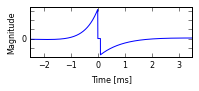

In [11]:
with mpl.rc_context(rcParams):
    fig, ax = plt.subplots(figsize=Asize)
    ax.plot(t*1e3, w_diff)
    ax.set_xlim(-2.5, 3.5)
    ax.set_ylim(-0.002, 0.0035)
    ax.set_yticklabels(['', '', 0, '', '', ''])
    ax.set_xlabel(u"Time [ms]", fontsize=8)
    ax.set_ylabel(u"Magnitude", fontsize=8)
    fig.savefig('../figs/03d-phase-diff-filter.pdf', bbox_inches='tight')

In [12]:
# Frequency shift
r = 1.05
dB = lambda x: 20*np.log10(abs(x))

fir208 = lockin.lock2(62e3, 2e3, 8e3, 1e6)
fir0502 = workups['0502-0V']['lis'][0].fir
x0, y0 = log_bins(workups['815-0V']['psd_f'], workups['815-0V']['psd_df'], r=r)
freq104, resp104 = sigutils.freqz(workups['104-10V']['lis'][0].fir, fs=1e6, xlim=(30, 10e3), xlog=True)
f208, resp208 = sigutils.freqz(fir208, fs=1e6, xlim=(30, 10e3), xlog=True)
f0502, resp0502 = sigutils.freqz(fir0502, fs=1e6, xlim=(30, 10e3), xlog=True)
r208dB = 20*np.log10(abs(resp208))
freq1, resp1 = sigutils.freqz(workups['815-0V']['lis'][0].fir, fs=1e6, xlim=(30, 20e3), xlog=True)

Response:
f   mag       dB
    0.000 1.000    0.000
 1000.000 0.983   -0.151
 2000.000 0.927   -0.657
 8000.000 0.095  -20.459
16000.000 0.000 -101.856
31000.000 0.000 -136.118
62000.000 0.000 -152.587
500000.000 0.000 -340.558


In [13]:
ax2x, ax2y = log_bins(workups['815-0V']['psd_f'],
           workups['815-0V']['psd_df']*abs(signal.freqz(workups['104-10V']['lis'][0].fir, worN=2*np.pi*workups['815-0V']['psd_f']/1e6)[1])**2,
                           r=1.05)
P_0208_factor = abs(signal.freqz(fir208, worN=2*np.pi*workups['815-0V']['psd_f']/1e6)[1])**2
x_208, y_208 = log_bins(workups['815-0V']['psd_f'],
           workups['815-0V']['psd_df']*abs(signal.freqz(fir208, worN=2*np.pi*workups['815-0V']['psd_f']/1e6)[1])**2,
                           r=1.05)

x_0502, y_0502 = log_bins(workups['815-0V']['psd_f'],
           workups['815-0V']['psd_df']*abs(signal.freqz(fir0502, worN=2*np.pi*workups['815-0V']['psd_f']/1e6)[1])**2,
                           r=1.05)

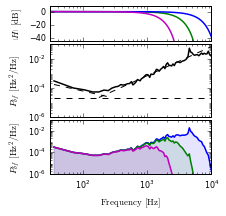

In [14]:
Bsize = (2.9, 3)
size=9

Pfm1 = 6e-3
Pf2 = 0.7e-9
Pf0 = 2e-5

with mpl.rc_context(rcParams):
    fig = plt.figure(figsize=Bsize)
    gs = gridspec.GridSpec(9, 1)
    gs.update(wspace=0.045, hspace=0.2) # set the spacing between axes.
    divs = [0, 2, 6, 9]
    axes = []
    for i in range(len(divs)-1):
        axes.append(fig.add_subplot(gs[divs[i]:divs[i+1], 0]))
    
    axes[0].semilogx(freq104, np.log10(abs(resp104))*20, color='g', linewidth=1.5)
    axes[0].semilogx(f208, r208dB, color='b', linewidth=1.5)
    axes[0].semilogx(f0502, dB(resp0502), color='m', linewidth=1.5)
    axes[1].loglog(x0, y0, 'k-', linewidth=1.5)
    axes[1].loglog(x0[x0 < 300], Pfm1/x0[x0 < 300], 'k--')
    axes[1].loglog(x0[x0 > 150], (Pf2*x0**2)[x0 > 150], 'k--')
    axes[1].loglog(x0, Pf0*np.ones_like(x0), 'k--')
    axes[2].loglog(x_208, y_208, color='b', linewidth=1.5)
    axes[2].loglog(ax2x, ax2y, color='g', linewidth=1.5)
    axes[2].loglog(x_0502, y_0502, color='m', linewidth=1.5)
    axes[2].fill_between(x_208, 1e-8, y_208, color='b', alpha=0.1)
    axes[2].fill_between(ax2x, 1e-8, ax2y, color='g', alpha=0.1)
    axes[2].fill_between(x_0502, 1e-8, y_0502, color='m', alpha=0.1)
    for ax in axes:
        ax.set_xlim(30, 10e3)
    axes[0].set_ylim(-45, 8)
    axes[2].set_ylim(1e-6, 1e-1)
    axes[1].set_ylim(1e-6, 1e-1)
    for ax in axes[1:]:
        ax.set_yticks(np.logspace(-6, -2, 3))
    for ax in axes[:-1]:
        ax.set_xticklabels([''])
    axes[2].set_xlabel(r"$\mathrm{Frequency} \: \:  [\mathrm{Hz}]$", fontsize=size)
    axes[2].set_ylabel(r"$P_{\delta f} \: \: [\mathrm{Hz}^2/\mathrm{Hz}]$", fontsize=size)
    axes[0].set_ylabel("$\\left | H \\right | \: \: [\\mathrm{dB}]$", fontsize=9)
    axes[1].set_ylabel(r"$P_{\delta f} \: \: [\mathrm{Hz}^2/\mathrm{Hz}]$", fontsize=size)
    axes[0].set_yticks(np.linspace(-40, 0, 3))
    fig.savefig('../figs/03b-frequency-noise.pdf', bbox_inches='tight')

## 2e

In [15]:
r = 1.05
xe, ye = log_bins(workups['815-0V']['psd_f'], workups['815-0V']['psd_phi'], r=r)
fe, mage = sigutils.freqz(w_diff, fs=1e6, xlim=(30, 10e3), xlog=True)

In [16]:
ax2ex, ax2ey = log_bins(workups['815-0V']['psd_f'],
           workups['815-0V']['psd_phi']*abs(signal.freqz(w_diff, worN=2*np.pi*workups['815-0V']['psd_f']/1e6)[1])**2 * P_0208_factor,
                           r=1.05)

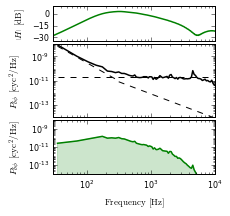

In [17]:

with mpl.rc_context(rcParams):
    fig = plt.figure(figsize=Bsize)
    gs = gridspec.GridSpec(9, 1)
    gs.update(wspace=0.045, hspace=0.2) # set the spacing between axes.
    divs = [0, 2, 6, 9]
    axes = []
    for i in range(len(divs)-1):
        axes.append(fig.add_subplot(gs[divs[i]:divs[i+1], 0]))
    
    axes[0].semilogx(fe, np.log10(abs(mage))*20, color='g', linewidth=1.5)
    axes[1].loglog(xe, ye, 'k-', linewidth=1.5)
    axes[1].loglog(xe[xe < 300], (0.05*Pfm1/xe**3)[xe < 300], 'k--')
    axes[1].loglog(xe[xe >= 300], (0.04*Pf0/xe**2)[xe>=300], 'k--')
    axes[1].loglog(xe, 0.03*Pf2*np.ones_like(xe), 'k--')
    
    axes[2].loglog(ax2ex, ax2ey, color='g', linewidth=1.5)
    axes[2].fill_between(ax2ex, 1e-24, ax2ey, color='g', alpha=0.2)
    for ax in axes:
        ax.set_xlim(30, 10e3)
    for ax in axes[:-1]:
        ax.set_xticklabels([''])
    axes[2].set_xlabel(r"$\mathrm{Frequency} \: \:  [\mathrm{Hz}]$", fontsize=size)
    axes[2].set_ylabel(r"$P_{\delta \phi} \: \: [\mathrm{cyc}^2/\mathrm{Hz}]$", fontsize=size)
    axes[0].set_ylabel("$\\left | H \\right | \: \: [\\mathrm{dB}]$", fontsize=9)
    axes[1].set_ylabel(r"$P_{\delta \phi} \: \: [\mathrm{cyc}^2/\mathrm{Hz}]$", fontsize=size)
    axes[0].set_ylim(-35, 10)
    for ax in axes[1:]:
        ax.set_ylim(1e-14, 1e-8)
        ax.set_yticks(np.logspace(-13, -9, 3))
    axes[0].set_yticks(np.linspace(-30, 0, 3))

    fig.savefig('../figs/03e-phase-noise.pdf', bbox_inches='tight')